In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


# 1.  Zero-Padding

<img src="Images/PAD.png" style="width:600px;height:400px;">
<caption><center> 
    <u> <font color='violet'> Figure 1
    </u><font color='violet'>  : Zero-Padding
        <br> Image (3 channels, RGB) with a padding of 2. 
        </center></caption>

In [7]:
def zero_pad(X, pad_width):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad_width -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    #np.pad(array, pad_width, mode='constant', **kwargs)
   
    X_pad = np.pad(X, ((0,0), (pad_width, pad_width), (pad_width, pad_width), (0,0)), 'constant', constant_values = 0)
  
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[-0.11305553 -0.1765054 ]
 [-0.68719598  0.11189723]
 [ 1.26597884  0.93401207]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


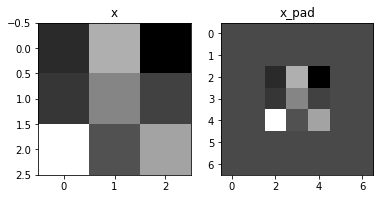

In [11]:
x = np.random.randn(4, 3, 3, 2)

x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

# Single step of convolution 

<img src="Images/sing_conv.gif" style="width:400px;height:200px;">
<caption><center> 
    <u> <font color='violet'> Figure 2
    </u><font color='violet'>  : Convolution
         
 </center></caption>

In [33]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W (filiter)-- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

   
    
    s = a_slice_prev * W
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = b.flatten()[0]+Z

    return Z

In [34]:
a_slice_prev = np.random.randn(4,4, 3)
W = np.random.randn( 4,4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = 6.509851097200569


#  Convolutional Neural Networks - Forward pass



<img src= "Images/conv_kiank.gif">

The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$


 
 <img src="Images/vert_horiz_kiank.png" style="width:400px;height:200px;">
<caption><center> 
    <u> <font color='violet'> Figure 4
    </u><font color='violet'>  :  Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)
This figure shows only a single channel.
 </center></caption>

In [104]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W(filter) -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    # Retrieve information from "hparameters"
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. (≈2 lines)
    n_H = int(((n_H_prev - f + (2 * pad)) / stride) + 1)
    n_W = int(((n_W_prev - f + (2 * pad)) / stride) + 1)
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]  
        
        # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                   
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    #print(W.shape)
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    return Z, cache

In [105]:
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 -0.8150661413306183
Z[3,2,1] =
 [  3.66881919 -10.3167882    4.67045589  -8.23415656   3.54423544
  -1.98620614   1.80621581   1.88782377]
cache_conv[0][1][2][3] =
 [ 0.07430034 -0.51470525  0.4335041   0.31305071]


# Pooling layer 


 
 <img src="Images/Average-versus-max-pooling.png" style="width:400px;height:200px;">
<caption><center> 
    <u> <font color='violet'> Figure 5
    </u><font color='violet'>  :  </center></caption>




###### The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. 
The two types of pooling layers are: 
- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.
###### These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. 
- ($f$) specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 


**Reminder**:

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [113]:

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C)) 
    
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [115]:
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)

print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[2.96917718 1.43104389 1.32405116]
   [1.13366245 1.46657372 1.05182156]]

  [[1.83334741 1.43104389 2.43258749]
   [1.46023981 2.13607302 2.43258749]]]


 [[[0.87231018 1.66409187 0.94456699]
   [0.87032792 2.15558002 2.62077624]]

  [[2.73784308 1.66409187 1.40367902]
   [1.43733954 2.15558002 1.21179286]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[ 0.69063363  0.12214228  0.15440403]
   [-0.31160425 -0.13278433 -0.0358489 ]]

  [[ 0.11870072  0.32706455  0.28263941]
   [ 0.02229982  0.24033557  0.40890973]]]


 [[[-0.18632755  0.31879087 -0.47235751]
   [-0.15587524  0.20872593  0.56626014]]

  [[ 0.13314775  0.05303114 -0.07760252]
   [-0.00300658  0.53093197  0.12490997]]]]


# Backpropagation in convolutional neural networks

In [116]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache[0], cache[1], cache[2], cache[3]
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
   
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape[0], dZ.shape[1], dZ.shape[2], dZ.shape[3]
    
    # Initialize dA_prev, dW, db with the correct shapes
    #print('APrev Shape ', A_prev.shape)
    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)   
    db = np.zeros(b.shape)
   

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
        
    for i in range(m):                       # loop over the training examples
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db
    

In [118]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 0.4304795745750833
dW_mean = 0.459888358145996
db_mean = 64.51355154941803


# Pooling layer - backward pass

- Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer.


### Max pooling - backward pass

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$


- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:

A[i,j] = True if X[i,j] = x

A[i,j] = False if X[i,j] != x

In [119]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    
    mask = (x == np.max(x))
    ### END CODE HERE ###
    
    return mask

In [121]:
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print()
print("mask = ", mask)

x =  [[-0.34007166  0.1723516  -2.02586202]
 [ 0.418294   -0.29506194 -0.13826691]]

mask =  [[False False False]
 [ True False False]]


###  Average pooling - backward pass 

$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [146]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    # Retrieve dimensions from shape 
    (n_H, n_W) = shape[0], shape[1]
    
    # Compute the value to distribute on the matrix 
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value
    a = np.full((n_H, n_W), average)
   
    
    return a

In [154]:
a = distribute_value(2, (2,2))

print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [155]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    
    # Retrieve information from cache 
    (A_prev, hparameters) = cache[0], cache[1]
    
    # Retrieve hyperparameters from "hparameters" 
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape 
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    m, n_H, n_W, n_C = dA.shape[0], dA.shape[1], dA.shape[2], dA.shape[3]
    
    # Initialize dA_prev with zeros 
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end,c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, vert_start: vert_end, horiz_start: horiz_end, c] 
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = dA[i,h,w,c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [157]:

A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.06256579838558003
dA_prev[1,1] =  [[0.         0.07638048]
 [0.         0.        ]
 [0.73446363 2.46579838]]

mode = average
mean of dA =  0.06256579838558003
dA_prev[1,1] =  [[-0.79492376  0.2492489 ]
 [-0.71195779  1.08512496]
 [ 0.08296597  0.83587606]]
